In [1]:
# DataFrame manipulation libraries:
import pandas as pd
import numpy as np

# Visualization libraries:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluation and processing libraries:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keras libraries:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [2]:
# Load in CSV data of top player performance per week in the 2015, 2016, 2017, and 2018 NFL seasons:
df = pd.read_csv('../../clean_data/player_weekly_performance_2018.csv')
df.head()  # preview first 5 rows of dataframe

,Rank,PlayerID,Name,Team,Position,Week,Opponent,PassingYards,PassingTouchdowns,PassingInterceptions,RushingYards,RushingTouchdowns,Receptions,ReceivingYards,ReceivingTouchdowns,FumblesLost,FantasyPoints,Date,Year
0,1,8283,Ryan Fitzpatrick,TB,QB,1,NO,417,4,0,36,1,0,0,0,0,42.28,2018-09-09,2018
1,2,18878,Alvin Kamara,NO,RB,1,TB,0,0,0,29,2,9,112,1,0,34.10,2018-09-09,2018
2,3,7242,Drew Brees,NO,QB,1,TB,439,3,0,0,0,0,0,0,0,31.56,2018-09-09,2018
3,4,18082,Tyreek Hill,KC,WR,1,LAC,0,0,0,4,0,7,169,2,0,29.30,2018-09-09,2018
4,5,18983,James Conner,PIT,RB,1,CLE,0,0,0,135,2,5,57,0,1,29.20,2018-09-09,2018


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d') # Convert 'Date' feature into a Pandas datetime object
df.dtypes  # examine data types of features

Rank                             int64
PlayerID                         int64
Name                            object
Team                            object
Position                        object
Week                             int64
Opponent                        object
PassingYards                     int64
PassingTouchdowns                int64
PassingInterceptions             int64
RushingYards                     int64
RushingTouchdowns                int64
Receptions                       int64
ReceivingYards                   int64
ReceivingTouchdowns              int64
FumblesLost                      int64
FantasyPoints                  float64
Date                    datetime64[ns]
Year                             int64
dtype: object

In [4]:
df.set_index('Date', inplace=True)  # set Date as the index
df.sort_index(inplace=True)         # sort the dataframe by the Date index
df.head()                           # examine first 5 rows to verify changes

,Rank,PlayerID,Name,Team,Position,Week,Opponent,PassingYards,PassingTouchdowns,PassingInterceptions,RushingYards,RushingTouchdowns,Receptions,ReceivingYards,ReceivingTouchdowns,FumblesLost,FantasyPoints,Year
Date,,,,,,,,,,,,,,,,,,
2018-09-09,1,8283,Ryan Fitzpatrick,TB,QB,1,NO,417,4,0,36,1,0,0,0,0,42.28,2018
2018-09-09,2,18878,Alvin Kamara,NO,RB,1,TB,0,0,0,29,2,9,112,1,0,34.10,2018
2018-09-09,3,7242,Drew Brees,NO,QB,1,TB,439,3,0,0,0,0,0,0,0,31.56,2018
2018-09-09,4,18082,Tyreek Hill,KC,WR,1,LAC,0,0,0,4,0,7,169,2,0,29.30,2018
2018-09-09,5,18983,James Conner,PIT,RB,1,CLE,0,0,0,135,2,5,57,0,1,29.20,2018


In [5]:
df.shape  # preview dataframe dimensions; 20,400 rows and 17 columns as features

(5100, 18)

In [6]:
# Convert player's team, opponent, and position into one-hot encoded variables to use for FFNN:
df_with_dummies = pd.get_dummies(df, columns=['Team', 'Opponent'], drop_first=False)

# Select feature variables to convert into floats; prevents errors when scaling data with StandardScaler:
features = [col for col in df_with_dummies.columns if col not in ['Name', 'Position', 'Week', 'Year', 'PlayerID']]
df_with_dummies[features] = df_with_dummies[features].astype(float)

# Assign X as features to be used for predicting weekly fantasy points per player:
X = df_with_dummies[[col for col in df_with_dummies.columns if col not in ['FantasyPoints', 'PlayerID']]]
# Assign target vector y as weekly fantasy points per player:
y = df_with_dummies['FantasyPoints']

In [7]:
X.dtypes  # verify that data types have been properly cast

Rank                    float64
Name                     object
Position                 object
Week                      int64
PassingYards            float64
PassingTouchdowns       float64
PassingInterceptions    float64
RushingYards            float64
RushingTouchdowns       float64
Receptions              float64
ReceivingYards          float64
ReceivingTouchdowns     float64
FumblesLost             float64
Year                      int64
Team_ARI                float64
Team_ATL                float64
Team_BAL                float64
Team_BUF                float64
Team_CAR                float64
Team_CHI                float64
Team_CIN                float64
Team_CLE                float64
Team_DAL                float64
Team_DEN                float64
Team_DET                float64
Team_GB                 float64
Team_HOU                float64
Team_IND                float64
Team_JAX                float64
Team_KC                 float64
                         ...   
Opponent

In [8]:
# Split X and y data into a training set and validation set:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# Scale all columns to use as predictive features using StandardScaler:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train.drop(columns = ['Name', 'Position', 'Week', 'Year']))
X_test_sc = ss.transform(X_test.drop(columns = ['Name', 'Position', 'Week', 'Year']))

In [10]:
X_test_sc[0:5]  # preview first 5 scaled X values in the validation data

array([[-0.07630398, -0.31715918, -0.26621033, -0.20776738, -0.45487011,
        -0.26056741,  1.15984546,  0.66307007, -0.39695878, -0.19570613,
        -0.17684817, -0.18074121, -0.19346525, -0.19053746, -0.17367869,
        -0.17447582, -0.16718097, -0.18151105, -0.18380366, -0.18227804,
        -0.18831599, -0.17996851, -0.17684817, -0.18151105,  5.89471488,
        -0.18074121, -0.17684817, -0.16215612, -0.17996851, -0.17841432,
        -0.19273688, -0.18304223, -0.17684817, -0.17606051, -0.19200614,
        -0.18151105, -0.17841432, -0.17919289, -0.17447582, -0.17606051,
        -0.18074121, -0.17367869, -0.18074121, -0.19273688, -0.17367869,
        -0.17919289, -0.17841432, -0.18456235, -0.18304223, -0.17447582,
        -0.17763276, -0.17606051, -0.18227804, -0.17919289, -0.19200614,
        -0.17526974, -0.17526974, -0.18831599, -0.17606051, -0.17126767,
        -0.17996851, -0.17207467, -0.18074121, -0.16964349, -0.18682237,
        -0.18380366, -0.18531834, -0.17287832, -0.1

In [11]:
X_test_sc.shape  # check shape of scaled X validation data

(1275, 74)

In [12]:
# Instantiate and build feed-forward neural network to predict player performance per week:
model = Sequential()                                        # instantiate model
model.add(Dense(74, activation='relu', input_shape=(74,)))  # input layer with 74 neurons
model.add(Dense(74, activation='relu'))                     # first hidden layer with 74 neurons
model.add(Dense(37, activation='relu'))                     # second hidden layer with 37 neurons
model.add(Dense(1))                                         # output layer with 1 neuron; represents predicted points

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

In [14]:
# Compile the FFNN model:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
# loss function = mean squared error
# optimization function = adam
# evaluation metric = mean absolute error

In [15]:
# Train the FFNN model using training, error is measured using validation data:
history = model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=150, 
                    batch_size=256) #, callbacks = [early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 3825 samples, validate on 1275 samples
Epoch 1/150
3825/3825 [==============================] - 0s 89us/step - loss: 89.1675 - mean_absolute_error: 6.2558 - val_loss: 61.4914 - val_mean_absolute_error: 5.0942
Epoch 2/150
3825/3825 [==============================] - 0s 19us/step - loss: 52.7074 - mean_absolute_error: 5.0683 - val_loss: 37.0221 - val_mean_absolute_error: 4.9124
Epoch 3/150
3825/3825 [==============================] - 0s 23us/step - loss: 33.5290 - mean_absolute_error: 4.8584 - val_loss: 25.2703 - val_mean_absolute_error: 4.3205
Epoch 4/150
3825/3825 [==============================] - 0s 26us/step - loss: 19.4901 - mean_absolute_error: 3.6546 - val_loss: 13.6399 - val_mean_absolute_error: 3.0717
Epoch 5/150
3825/3825 [==============================] - 0s 26us/step - loss: 9.4583 - mean_absolute_error: 2.5087 - val_loss: 6.1760 - val_mean_absolute_error: 1.9831
Epoch 6/150
3825/3825 [==============================] -

Epoch 48/150
3825/3825 [==============================] - 0s 21us/step - loss: 0.0774 - mean_absolute_error: 0.2009 - val_loss: 0.2306 - val_mean_absolute_error: 0.3279
Epoch 49/150
3825/3825 [==============================] - 0s 22us/step - loss: 0.0753 - mean_absolute_error: 0.1980 - val_loss: 0.2311 - val_mean_absolute_error: 0.3275
Epoch 50/150
3825/3825 [==============================] - 0s 25us/step - loss: 0.0729 - mean_absolute_error: 0.1948 - val_loss: 0.2307 - val_mean_absolute_error: 0.3274
Epoch 51/150
3825/3825 [==============================] - 0s 23us/step - loss: 0.0708 - mean_absolute_error: 0.1914 - val_loss: 0.2289 - val_mean_absolute_error: 0.3246
Epoch 52/150
3825/3825 [==============================] - 0s 15us/step - loss: 0.0692 - mean_absolute_error: 0.1903 - val_loss: 0.2272 - val_mean_absolute_error: 0.3244
Epoch 53/150
3825/3825 [==============================] - 0s 14us/step - loss: 0.0686 - mean_absolute_error: 0.1884 - val_loss: 0.2277 - val_mean_absolute_

3825/3825 [==============================] - 0s 14us/step - loss: 0.0352 - mean_absolute_error: 0.1335 - val_loss: 0.2093 - val_mean_absolute_error: 0.3018
Epoch 97/150
3825/3825 [==============================] - 0s 15us/step - loss: 0.0341 - mean_absolute_error: 0.1299 - val_loss: 0.2170 - val_mean_absolute_error: 0.3056
Epoch 98/150
3825/3825 [==============================] - 0s 14us/step - loss: 0.0328 - mean_absolute_error: 0.1259 - val_loss: 0.2170 - val_mean_absolute_error: 0.3051
Epoch 99/150
3825/3825 [==============================] - 0s 13us/step - loss: 0.0322 - mean_absolute_error: 0.1255 - val_loss: 0.2135 - val_mean_absolute_error: 0.3017
Epoch 100/150
3825/3825 [==============================] - 0s 13us/step - loss: 0.0309 - mean_absolute_error: 0.1220 - val_loss: 0.2125 - val_mean_absolute_error: 0.3026
Epoch 101/150
3825/3825 [==============================] - 0s 13us/step - loss: 0.0314 - mean_absolute_error: 0.1236 - val_loss: 0.2132 - val_mean_absolute_error: 0.30

3825/3825 [==============================] - 0s 13us/step - loss: 0.0212 - mean_absolute_error: 0.0981 - val_loss: 0.2132 - val_mean_absolute_error: 0.2968
Epoch 145/150
3825/3825 [==============================] - 0s 13us/step - loss: 0.0208 - mean_absolute_error: 0.0967 - val_loss: 0.2153 - val_mean_absolute_error: 0.2975
Epoch 146/150
3825/3825 [==============================] - 0s 13us/step - loss: 0.0207 - mean_absolute_error: 0.0964 - val_loss: 0.2143 - val_mean_absolute_error: 0.2978
Epoch 147/150
3825/3825 [==============================] - 0s 12us/step - loss: 0.0202 - mean_absolute_error: 0.0951 - val_loss: 0.2161 - val_mean_absolute_error: 0.2978
Epoch 148/150
3825/3825 [==============================] - 0s 13us/step - loss: 0.0203 - mean_absolute_error: 0.0956 - val_loss: 0.2176 - val_mean_absolute_error: 0.2988
Epoch 149/150
3825/3825 [==============================] - 0s 13us/step - loss: 0.0200 - mean_absolute_error: 0.0943 - val_loss: 0.2163 - val_mean_absolute_error: 0

In [16]:
preds = model.predict(X_test_sc)  # generate predictions on validation data
preds  # preview predictions

array([[4.5343118e+00],
       [1.6986731e+00],
       [1.2164838e+00],
       ...,
       [1.3426905e-03],
       [2.4433663e+00],
       [9.7396779e-01]], dtype=float32)

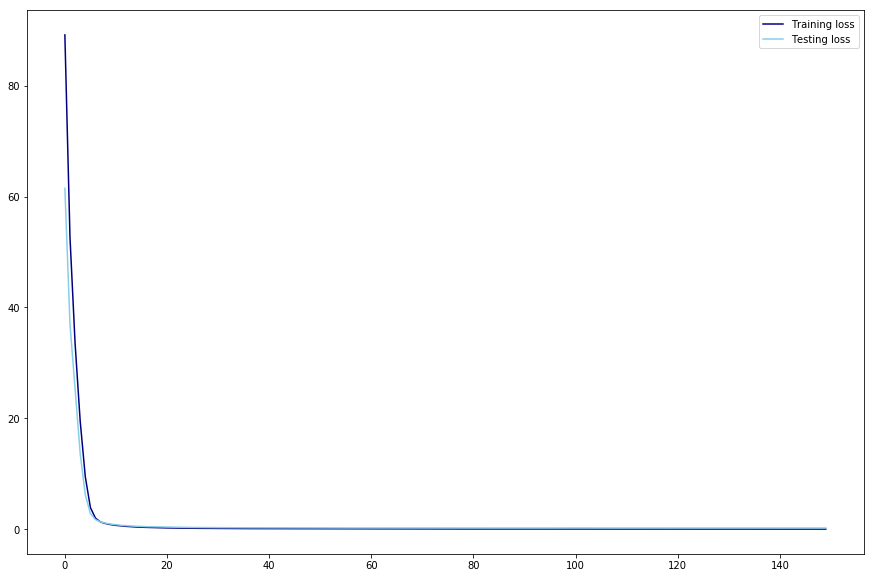

In [17]:
# Save training data loss and validation data loss as variables to plot:
train_loss = history.history['loss']     # 'loss' = mean squared error of training data
test_loss = history.history['val_loss']  # 'val_loss' = mean squared error of validation data

# Plot training and testing loss for the FFNN model:
plt.figure(figsize=(15, 10))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

# Save figure as a PNG file:
plt.savefig('../../images/FFNN_fantasy_training_vs_testing_loss_function_2018.png')

In [18]:
# Assign predicted fantasy points to validation data as a new column:
X_test['Predicted_FP'] = preds

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# Assign true fantasy points to validation data as a new column:
X_test['FantasyPoints'] = y_test

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
X_test.head()  # preview first 5 rows of validation data
# Now, predicted fantasy points per week can be visually compared to true values and all other data columns.

,Rank,Name,Position,Week,PassingYards,PassingTouchdowns,PassingInterceptions,RushingYards,RushingTouchdowns,Receptions,...,Opponent_OAK,Opponent_PHI,Opponent_PIT,Opponent_SEA,Opponent_SF,Opponent_TB,Opponent_TEN,Opponent_WAS,Predicted_FP,FantasyPoints
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-09,140.0,Donte Moncrief,WR,14,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.534312,4.7
2018-12-02,214.0,Zach Pascal,WR,13,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.698673,1.8
2018-09-23,245.0,Kenyan Drake,RB,3,0.0,0.0,0.0,3.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.216484,1.0
2018-12-30,64.0,Rod Smith,RB,17,0.0,0.0,0.0,35.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.865455,10.9
2018-09-09,80.0,Adam Thielen,WR,1,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.735585,10.2


In [21]:
# Calculate and display validation data MSE and RMSE:
test_mse = mean_squared_error(preds, y_test)
print('MSE = ', test_mse)
print('RMSE = ', np.sqrt(test_mse))

MSE =  0.21407178808299282
RMSE =  0.46267892547963846


In [22]:
# Calculate and display training data MSE and RMSE:
train_preds = model.predict(X_train_sc)
train_mse = mean_squared_error(train_preds, y_train)
print('MSE = ', train_mse)
print('RMSE = ', np.sqrt(train_mse))

MSE =  0.019082231778812152
RMSE =  0.13813845148550113
